In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121  # or cpu wheels
!pip install snntorch tonic

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 12.9 MB/s eta 0:00:00
  Created wheel for expelliarmus: filename=expelliarmus-1.1.12-cp312-cp312-linux_x86_64.whl size=56413 sha256=f90940af275539f7250738877127325679b07f1c37406f32aa21a669704018fc
  Stored in directory: /root/.cache/pip/wheels/9a/9e/4b/f96da4dab397e63f90078766122e078e4ba82b2b48e07ee644
Successfully built expelliarmus
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver doe

1.   Loads the N-MNIST event-based dataset.
1.   Transforms continuous events → frame-based tensor representation using ToFrame.
2.   Builds PyTorch DataLoaders for training/testing.

2.   Shows the shape of one sample: [time_bins, 2, H, W].






In [ ]:
import torch
from torch.utils.data import DataLoader
import tonic
import tonic.transforms as ttf

# ---- data & transforms ----
root = "./data"

# time binning: e.g., 100 time bins across the sample duration
time_bins = 100

transform = ttf.ToFrame(sensor_size=tonic.datasets.NMNIST.sensor_size,
                        n_time_bins=time_bins,
                        include_incomplete=True) # keep all events

train_ds = tonic.datasets.NMNIST(save_to=root, train=True, transform=transform)
test_ds  = tonic.datasets.NMNIST(save_to=root, train=False, transform=transform)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# peek one sample (frames: [T, C, H, W])
sample_frames, label = train_ds[0]    # torch.Tensor
print(sample_frames.shape, label)     # e.g., [T, 2, 34, 34] or [T, 2, 28, 28] depending on transform

  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./data/NMNIST/train.zip to ./data/NMNIST


  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting ./data/NMNIST/test.zip to ./data/NMNIST
(100, 2, 34, 34) 0


**A) show_time_slices**

*   Shows how event counts accumulate across three time bins.
*   Helps visualize temporal evolution of the digit.
*   Uses the ON-channel of the framed tensor.

**B) Raw event scatter**

*   Visualizes raw (x, y) event spikes from the first 10% of the recording.
*   Shows the fine-grained spiking pattern produced by an event camera.
*   Helps understand how sparse event data looks before binning.









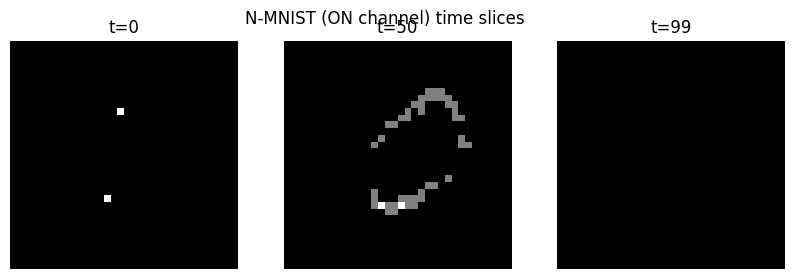

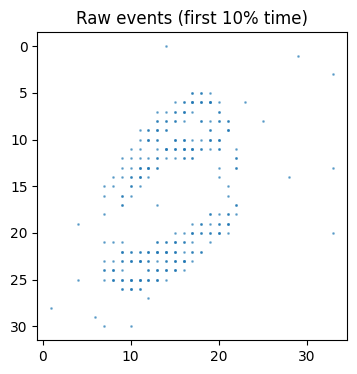

In [ ]:
import matplotlib.pyplot as plt

# (A) visualize 3 time slices
def show_time_slices(frames, title="N-MNIST (ON channel) time slices"):
    # frames: [T, C, H, W]
    on = frames[:, 0]                   # ON channel
    T = on.shape[0]
    idxs = torch.linspace(0, T-1, steps=3).round().int().tolist()
    plt.figure(figsize=(10,3))
    for i, ti in enumerate(idxs, 1):
        plt.subplot(1,3,i)
        plt.imshow(on[ti], cmap="gray")
        plt.title(f"t={ti}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_time_slices(sample_frames)

# (B) optional: view raw events (no transform)
raw_ds = tonic.datasets.NMNIST(save_to=root, train=True)  # no transform
events, _ = raw_ds[0]  # dict-like arrays x,y,t,p
plt.figure(figsize=(4,4))
mask = events['t'] < (events['t'].min() + (events['t'].max()-events['t'].min())*0.1)
plt.scatter(events['x'][mask], events['y'][mask], s=1, alpha=0.5)
plt.gca().invert_yaxis(); plt.title("Raw events (first 10% time)"); plt.show()

## This SNN processes event frames over time:

1. Each time bin frame is flattened

2. Passed into a fully connected layer

3. Spikes and membrane potentials are computed via LIF neurons

4. Repeated sequentially for all T time bins

5. Output spikes are summed → prediction

This is a rate-coded spiking classifier, very common in SNN research.

In [ ]:
import torch.nn as nn
import snntorch as snn
from snntorch import functional as SF

device = "cuda" if torch.cuda.is_available() else "cpu"

# infer shape from a batch
batch_frames, batch_labels = next(iter(train_dl))  # [B, T, C, H, W] or [T, C, H, W]? -> ToFrame gives per-sample [T,C,H,W]
# DataLoader stacks: shape [B, T, C, H, W]
B, T, C, H, W = batch_frames.shape

# simple feedforward SNN: flatten per frame -> linear -> LIF -> output layer (10 classes)
num_classes = 10
hidden = 256

class TinySNN(nn.Module):
    def __init__(self, H, W, C, hidden, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(C*H*W, hidden)
        self.lif1 = snn.Leaky(beta=0.9)          # LIF neuron (snnTorch)
        self.fc2 = nn.Linear(hidden, num_classes)
        self.lif2 = snn.Leaky(beta=0.9)

    def forward(self, x):  # x: [B, T, C, H, W]
        mem1 = self.lif1.init_leaky(); mem2 = self.lif2.init_leaky()
        spk2_rec = []  # record output spikes over time

        for t in range(x.size(1)):  # unroll over time
            xt = self.flatten(x[:, t])             # [B, C*H*W]
            cur1 = self.fc1(xt)
            spk1, mem1 = self.lif1(cur1, mem1)     # hidden spikes

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)     # output spikes
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec, dim=1)         # [B, T, num_classes]

model = TinySNN(H, W, C, hidden, num_classes).to(device)
batch_frames = batch_frames.to(device).float()

# forward pass
with torch.no_grad():
    out_spikes = model(batch_frames)                # [B, T, 10]
    spike_counts = out_spikes.sum(dim=1)            # [B, 10] rate-coded readout
    preds = spike_counts.argmax(dim=1)              # class prediction

print("Output spike counts (first sample):", spike_counts[0].cpu().numpy())
print("Predicted label vs true:", preds[0].item(), batch_labels[0].item())


Output spike counts (first sample): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted label vs true: 0 1


1. Sets up a fully reproducible environment

    Seeds, deterministic CUDNN.

2. Loads NMNIST event data

    Transforms events → frame stacks.

3. Normalizes event frames (optional but recommended)

    Turn integer event counts into floating-point intensities.

4. Builds DataLoaders

    Configured for speed (num_workers, pin_memory).

5. Inspects one batch

Determines [B, T, C, H, W], required for designing an SNN model.

This script is the entire data-loading pipeline needed for SNN training on NMNIST.

In [ ]:
import os, json, time, math, random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import snntorch as snn
from snntorch import functional as SF
import tonic
import tonic.transforms as ttf

# Reproducibility
seed = 123
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "gpu"
print("Device:", device)

# ---- Data / transforms ----
root = "./data"
os.makedirs(root, exist_ok=True)

TIME_BINS = 50            # try 100 for a bit more accuracy
BATCH_SIZE = 64           # 64 or 128 works well
NUM_WORKERS = 2

# Convert event streams to frame stacks with ON/OFF channels
to_frame = ttf.ToFrame(
    sensor_size=tonic.datasets.NMNIST.sensor_size,  # (34,34,2)
    n_time_bins=TIME_BINS,
    include_incomplete=True
)

# Optional: normalize frames to {0,1}
# Frames from ToFrame are counts per bin; clip & scale if desired
class ClipUnit(object):
    def __call__(self, frames):
        # frames: [T, C, H, W] integer counts
        mx = frames.max().clip(min=1)
        return (frames.astype(np.float32) / mx).clip(0, 1)

transform = ttf.Compose([to_frame, ClipUnit()])

train_ds = tonic.datasets.NMNIST(save_to=root, train=True, transform=transform)
test_ds  = tonic.datasets.NMNIST(save_to=root, train=False, transform=transform)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)
print("Samples:", len(train_ds), len(test_ds))

# Peek one batch to infer shapes
x0, y0 = next(iter(train_dl))  # x0: [B, T, C, H, W]
B, T, C, H, W = x0.shape
print(f"Batch shape: {x0.shape} (T={T}, C={C}, H={H}, W={W})")

Device: cuda
Samples: 60000 10000
Batch shape: torch.Size([64, 50, 2, 34, 34]) (T=50, C=2, H=34, W=34)


1. Training setup

    Learning rate is set to 1e-3.

    Training will run for 8 epochs (but is easy to extend).

    The optimizer is Adam, with weight decay for mild regularization.

    Classification uses cross-entropy loss computed on the spike counts.

2. step_batch: process one minibatch

    This function performs all computation for a single batch:

    Inputs

    A batch (x, y), where:

        x: spiking frames [B, T, C, H, W]

        y: labels [B]

    Procedure

    Move inputs to device and cast types.

    Forward pass:

        The model returns spikes [B, T, 10].

        Sum spikes across time → rate-coded logits [B, 10].

    Compute the cross-entropy loss.

    If training:

        Zero gradients.

        Backpropagate through surrogate gradients.

        Update model weights.

        Compute accuracy (argmax on spike counts).

        Returns loss_value, accuracy_value

3. evaluate: full-dataset evaluation

    This function computes average loss and accuracy over an entire dataloader:

        Sets the model to inference mode.

        Iterates over all batches without gradient tracking.

        Calls step_batch(..., train=False) to reuse the same forward logic.

    Accumulates:

    total loss

    total accuracy

    number of samples

    Returns dataset-wide mean loss and mean accuracy.

In [ ]:
lr = 1e-3
epochs = 15
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

def step_batch(batch, train=True):
    model.train(train)
    x, y = batch
    x = x.to(device).float()   # [B,T,C,H,W]
    y = y.to(device).long()

    out_spk = model(x)         # [B,T,10]
    spike_counts = out_spk.sum(dim=1)    # [B,10]
    loss = criterion(spike_counts, y)

    if train:
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        pred = spike_counts.argmax(dim=1)
        acc = (pred == y).float().mean().item()
    return loss.item(), acc

def evaluate(loader):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    with torch.no_grad():
        for batch in loader:
            loss, acc = step_batch(batch, train=False)
            bs = batch[0].size(0)
            total_loss += loss * bs
            total_acc  += acc * bs
            n += bs
    return total_loss / n, total_acc / n


step_batch handles one forward/backward step:

1. Forward SNN → sum spikes → compute loss → update weights (if training).

2. Computes batch accuracy.

evaluate loops over batches to compute full dataset performance:

1. Uses the same logic but without weight updates.

2. Produces loss and accuracy metrics for validation/testing.

Spike summation (rate-coded readout) converts temporal spike trains into class scores, suitable for CrossEntropyLoss.

In [ ]:
save_dir = "./runs/nmnist_baseline"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "model.pt")
results_path = os.path.join(save_dir, "results.json")

history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
best_acc = 0.0
start = time.time()

for ep in range(1, epochs+1):
    # Train epoch
    model.train()
    tr_loss, tr_acc, n = 0.0, 0.0, 0
    for batch in train_dl:
        loss, acc = step_batch(batch, train=True)
        bs = batch[0].size(0)
        tr_loss += loss * bs
        tr_acc  += acc * bs
        n += bs
    tr_loss /= n; tr_acc /= n

    # Eval
    te_loss, te_acc = evaluate(test_dl)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["test_loss"].append(te_loss)
    history["test_acc"].append(te_acc)

    # Save best
    if te_acc > best_acc:
        best_acc = te_acc
        torch.save({"model_state": model.state_dict(),
                    "meta": {"time_bins": TIME_BINS, "hidden": 256, "beta": 0.9}},
                   model_path)

    print(f"Epoch {ep:02d}/{epochs} | "
          f"Train L {tr_loss:.4f} A {tr_acc:.3f} | "
          f"Test L {te_loss:.4f} A {te_acc:.3f} | Best {best_acc:.3f}")

# Dump results
payload = {
    "time_bins": TIME_BINS,
    "batch_size": BATCH_SIZE,
    "epochs": epochs,
    "best_test_acc": best_acc,
    "history": history
}
with open(results_path, "w") as f:
    json.dump(payload, f, indent=2)

print("Training done in", f"{(time.time()-start)/60:.1f} min")
print("Best Test Accuracy:", round(best_acc, 4))
print("Saved:", model_path, "and", results_path)


Epoch 01/15 | Train L 0.3128 A 0.901 | Test L 0.1491 A 0.954 | Best 0.954
Epoch 02/15 | Train L 0.1254 A 0.961 | Test L 0.1068 A 0.967 | Best 0.967
Epoch 03/15 | Train L 0.0836 A 0.974 | Test L 0.0813 A 0.974 | Best 0.974
Epoch 04/15 | Train L 0.0626 A 0.980 | Test L 0.0883 A 0.972 | Best 0.974
Epoch 05/15 | Train L 0.0488 A 0.984 | Test L 0.0733 A 0.976 | Best 0.976
Epoch 06/15 | Train L 0.0377 A 0.987 | Test L 0.0638 A 0.979 | Best 0.979
Epoch 07/15 | Train L 0.0297 A 0.990 | Test L 0.0656 A 0.978 | Best 0.979
Epoch 08/15 | Train L 0.0250 A 0.992 | Test L 0.0661 A 0.980 | Best 0.980
Epoch 09/15 | Train L 0.0223 A 0.993 | Test L 0.0721 A 0.978 | Best 0.980
Epoch 10/15 | Train L 0.0178 A 0.994 | Test L 0.0772 A 0.978 | Best 0.980
Epoch 11/15 | Train L 0.0186 A 0.993 | Test L 0.0727 A 0.981 | Best 0.981
Epoch 12/15 | Train L 0.0138 A 0.995 | Test L 0.0663 A 0.981 | Best 0.981
Epoch 13/15 | Train L 0.0140 A 0.996 | Test L 0.0829 A 0.975 | Best 0.981
Epoch 14/15 | Train L 0.0135 A 0.995 |

1. Checkpointing allows training to resume or models to be evaluated later.

2. Loading weights ensures exact same trained parameters are restored.

3. Evaluation gives an objective performance measure on unseen data.

4. Useful for:

*   Testing best-performing models
*   Comparing experiments
*   Sharing trained models









In [ ]:
ckpt = torch.load(model_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
test_loss, test_acc = evaluate(test_dl)
print("Reloaded model → Test Acc:", round(test_acc, 4))


Reloaded model → Test Acc: 0.9813


1. Mimicry Attack simulates realistic small perturbations to spike trains.

2. Evaluation helper measures how these perturbations affect SNN performance.

3. Statistics collection quantifies the extent of perturbation (e.g., fraction of spikes changed).

4. Saving results ensures reproducibility and allows plotting/analyzing accuracy degradation.

In [ ]:
# Put this block after your Phase 2 training code.
import os, json, time
import torch
import numpy as np

# ---------- mimicry attack function ----------
def mimicry_attack(spike_trains,
                   shift_ms=2.0,
                   add_prob=0.1,
                   delete_prob=0.05,
                   total_time_ms=300.0,
                   rng=None,
                   per_pixel_shift=True):
    """
    Apply mimicry perturbations to spike_trains.

    Args:
      spike_trains: torch.Tensor [B, T, C, H, W] (binary or floats 0/1)
      shift_ms: float, max absolute timing shift in milliseconds (applied per pixel)
      add_prob: probability of adding a spike at any 0 location (per time-step)
      delete_prob: probability of deleting an existing spike (per time-step)
      total_time_ms: duration represented by the T time bins (ms)
      rng: optional np.random.RandomState or torch.Generator for reproducibility
      per_pixel_shift: if True, random shift applied per pixel channel; if False, single shift per sample
    Returns:
      perturbed_spikes: tensor same shape as input
      stats: dict with perturbation counts/fractions
    """
    if rng is None:
        rng = np.random

    device = spike_trains.device
    B, T, C, H, W = spike_trains.shape
    spikes = spike_trains.clone()

    # convert shift_ms -> steps
    step_ms = float(total_time_ms) / float(T)
    if step_ms <= 0:
        raise ValueError("total_time_ms must be > 0")
    shift_steps = int(round(shift_ms / step_ms))
    # clamp shift_steps to T-1
    shift_steps = max(0, min(shift_steps, T-1))

    # 1) Timing shift (small roll)
    # Build random shifts in range [-shift_steps, shift_steps]
    if shift_steps > 0:
        if per_pixel_shift:
            # draw shifts per B,C,H,W (i.e., every pixel channel may get different shift)
            # to save memory, draw per (B, C, H, W) then broadcast
            shifts = rng.randint(-shift_steps, shift_steps+1, size=(B, C, H, W))
            # apply roll for each sample and channel pixel
            pert = torch.zeros_like(spikes)
            for b in range(B):
                for c in range(C):
                    # shifts for all pixels in this sample/channel
                    s_mat = shifts[b, c]  # shape (H, W) integers
                    # iterate pixels (H*W not too big for 34x34)
                    for y in range(H):
                        for x in range(W):
                            s = int(s_mat[y, x])
                            if s == 0:
                                pert[b, :, c, y, x] = spikes[b, :, c, y, x]
                            else:
                                pert[b, :, c, y, x] = torch.roll(spikes[b, :, c, y, x], shifts=s, dims=0)
            spikes = pert
        else:
            # single shift per sample (all pixels shifted same amount)
            shifts = rng.randint(-shift_steps, shift_steps+1, size=(B,))
            pert = torch.zeros_like(spikes)
            for b in range(B):
                s = int(shifts[b])
                if s == 0:
                    pert[b] = spikes[b]
                else:
                    pert[b] = torch.roll(spikes[b], shifts=s, dims=0)  # roll along T dim
            spikes = pert

    # 2) Delete Spikes: randomly drop some existing spikes (1 -> 0)
    if delete_prob > 0:
        ones_mask = (spikes > 0.5).float()
        # Bernoulli mask: 1 = keep, 0 = delete (so we multiply by keep_mask)
        keep_mask = torch.from_numpy(rng.binomial(1, 1.0 - delete_prob, size=ones_mask.shape)).to(device).float()
        # Only apply deletion where spikes exist
        spikes = spikes * (ones_mask * keep_mask + (1 - ones_mask))  # zeros remain zero

    # 3) Add Spikes: randomly set some zero positions to 1
    if add_prob > 0:
        zeros_mask = (spikes <= 0.5).float()
        add_mask = torch.from_numpy(rng.binomial(1, add_prob, size=zeros_mask.shape)).to(device).float()
        spikes = torch.clamp(spikes + (zeros_mask * add_mask), 0.0, 1.0)

    # Stats: compute how many positions changed relative to input
    total_positions = float(spike_trains.numel())
    changed = (spike_trains != spikes).float().sum().item()
    stats = {
        "total_positions": int(total_positions),
        "changed_count": int(changed),
        "changed_fraction": float(changed / total_positions),
        "shift_steps": shift_steps,
        "add_prob": add_prob,
        "delete_prob": delete_prob
    }
    return spikes, stats


# ---------- evaluation helpers ----------
@torch.no_grad()
def evaluate_perturbed(model, loader, attack_fn, attack_kwargs, device="cpu", max_batches=None):
    """
    Evaluate model on perturbed data generated on the fly.
    Returns (clean_acc, perturbed_acc, stats_agg)
    """
    model.eval()
    total_clean_correct = 0
    total_perturbed_correct = 0
    total_samples = 0
    stats_list = []

    for i, (x_batch, y_batch) in enumerate(loader):
        if max_batches is not None and i >= max_batches:
            break
        x = x_batch.to(device).float()     # [B,T,C,H,W]
        y = y_batch.to(device)

        # Clean prediction
        out_spk = model(x)                 # [B,T,classes]
        clean_counts = out_spk.sum(dim=1)  # [B,classes]
        clean_preds = clean_counts.argmax(dim=1)
        total_clean_correct += (clean_preds == y).sum().item()

        # Perturb (note: attack works on binned spikes; if input is counts, binarize first)
        # Binarize input (treat >0 as spike)
        x_bin = (x > 0.5).float()
        pert_x_bin, stats = attack_fn(x_bin, **attack_kwargs)
        stats_list.append(stats)

        # Forward on perturbed input (we keep float)
        out_spk_p = model(pert_x_bin)
        pert_counts = out_spk_p.sum(dim=1)
        pert_preds = pert_counts.argmax(dim=1)
        total_perturbed_correct += (pert_preds == y).sum().item()

        total_samples += x.size(0)

    clean_acc = total_clean_correct / total_samples
    pert_acc = total_perturbed_correct / total_samples

    # Aggregate stats
    avg_changed_frac = float(np.mean([s["changed_fraction"] for s in stats_list]))
    stats_agg = {"avg_changed_fraction": avg_changed_frac, "per_batch": stats_list}
    return clean_acc, pert_acc, stats_agg


# ---------- run attack evaluation ----------
# Example parameters - tune to get large degradation
attack_kwargs = {
    "shift_ms": 2.0,          # e.g., 2 ms
    "add_prob": 0.10,         # 10% chance to add spikes where zeros exist
    "delete_prob": 0.05,      # 5% chance to delete existing spikes
    "total_time_ms": 300.0,   # duration your bins represent
    "rng": np.random.RandomState(42),
    "per_pixel_shift": True
}

# Evaluate on test set (use test_dl from Phase 2); consider limiting max_batches for quick runs
clean_acc, pert_acc, stats_agg = evaluate_perturbed(model, test_dl, mimicry_attack, attack_kwargs, device=device, max_batches=None)

print(f"Clean Accuracy:  {clean_acc*100:.2f}%")
print(f"Perturbed Accuracy: {pert_acc*100:.2f}%")
print("Attack stats (avg changed fraction):", stats_agg["avg_changed_fraction"])

# Save results
out_dir = "./runs/nmnist_attack"
os.makedirs(out_dir, exist_ok=True)
results = {
    "attack_kwargs": {k: (v if k not in ("rng",) else None) for k,v in attack_kwargs.items()},
    "clean_acc": float(clean_acc),
    "perturbed_acc": float(pert_acc),
    "stats_agg": stats_agg
}
with open(os.path.join(out_dir, "mimicry_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print("Saved results to", os.path.join(out_dir, "mimicry_results.json"))


Clean Accuracy:  98.13%
Perturbed Accuracy: 13.74%
Attack stats (avg changed fraction): 0.09990568799175721
Saved results to ./runs/nmnist_attack/mimicry_results.json


## Logic for Spike Jitter

1. Convert max_jitter_ms → number of time-step shifts (jitter_steps).

2. For each spike:

    With probability p_shift_per_spike = 0.5, decide whether to jitter.

    If jittering, pick a random shift in [-jitter_steps, +jitter_steps].

3. Apply the shift along the temporal dimension (T) using torch.roll.

4. Ensure output remains binary (0/1).

5. Return the jittered spike tensor.

## Logic for Poisson Noise Injection

1. Identify zero positions in spike_trains.

2. Generate random spikes at zero positions using Bernoulli distribution (noise_rate).

3. Add these spikes to the original tensor.

4. Clip values to [0,1] to maintain binary representation.

5. Return the noisy spike tensor.

In [ ]:
import torch
import numpy as np
import json, os

# --------- Defense: Spike Jitter ----------
def spike_jitter(spike_trains, max_jitter_ms=1.0, total_time_ms=300.0, rng=None):
    """
    Randomly jitter spike times by up to +/- max_jitter_ms.
    Input/Output: torch.Tensor [B,T,C,H,W] binary (0/1 floats)
    Jitter is applied by rolling the T-dimension per-spike randomly.
    """
    if rng is None:
        rng = np.random
    device = spike_trains.device
    B, T, C, H, W = spike_trains.shape

    step_ms = float(total_time_ms) / float(T)
    jitter_steps = int(round(max_jitter_ms / step_ms))
    jitter_steps = max(0, min(jitter_steps, T-1))

    # Work on a clone
    x = spike_trains.clone()

    if jitter_steps == 0:
        return x  # nothing to do

    # For efficiency: vectorize per (B,C,H,W) shifts like Phase 3 but jitter each spike probabilistically
    # Approach: For each time step t, for each pixel, decide whether to shift its spike and by how many steps
    # We'll produce a rolled version per chosen shift value and combine via masks.

    # Pre-generate shifts in range [-jitter_steps..+jitter_steps] with probability p_shift_per_spike
    # Instead of shifting every spike, only shift spikes with some probability to reduce excessive corruption.
    p_shift_per_spike = 0.5  # PROBABILITY that an existing spike will be jittered (tuneable)
    # Create mask of existing spikes
    spikes_mask = (x > 0.5).float().cpu().numpy()  # shape (B,T,C,H,W)

    # Preallocate output
    out = torch.zeros_like(x)

    # We'll iterate over possible shift values and apply mask where chosen
    shift_range = np.arange(-jitter_steps, jitter_steps+1)
    # random choice per spike among shift_range with probability p_shift_per_spike or 0 (no shift)
    # For memory reasons, do per-batch
    for b in range(B):
        # for each possible shift, create rolled version once
        rolled_versions = {}
        for s in shift_range:
            rolled_versions[s] = torch.roll(x[b], shifts=int(s), dims=0)

        # default no-shift component (keep spikes that are not chosen to be jittered)
        keep_mask = (rng.binomial(1, 1.0 - p_shift_per_spike, size=spikes_mask[b].shape)).astype(np.float32)
        keep_mask = torch.from_numpy(keep_mask).to(device)
        out_b = x[b] * keep_mask  # keep non-shifted spikes

        # For spikes chosen to shift, decide shift amount uniformly
        shift_choice = rng.randint(-jitter_steps, jitter_steps+1, size=spikes_mask[b].shape)
        shift_choice = torch.from_numpy(shift_choice).to(device).long()

        # Apply shifted spikes where original spike existed and where we didn't keep it
        to_shift_mask = (spikes_mask[b] > 0.5).astype(np.float32) * (1 - keep_mask.cpu().numpy())
        to_shift_mask = torch.from_numpy(to_shift_mask).to(device).float()

        # For each shift s, add rolled_versions[s] * mask_s
        for s in shift_range:
            mask_s = (shift_choice == s).float() * to_shift_mask
            if mask_s.sum() > 0:
                out_b = out_b + rolled_versions[s] * mask_s

        # clip to 0/1
        out[b] = out_b.clamp(0, 1)

    return out


# --------- Defense: Poisson Noise Injection ----------
def poisson_noise_injection(spike_trains, noise_rate=0.01, total_time_ms=300.0, rng=None):
    """
    Inject Poisson noise (random spikes) into zero positions.
    noise_rate: average spikes per (time-step, pixel) as probability in [0,1].
    """
    if rng is None:
        rng = np.random
    device = spike_trains.device
    B, T, C, H, W = spike_trains.shape

    x = spike_trains.clone()

    # Only add where there is no spike currently
    zeros_mask = (x <= 0.5).float().cpu().numpy()
    add_mask = rng.binomial(1, noise_rate, size=zeros_mask.shape).astype(np.float32)
    add_mask = torch.from_numpy(add_mask).to(device)

    x = torch.clamp(x + ( (1 - (x>0.5).float()) * add_mask ), 0.0, 1.0)
    return x


Provides a single interface to combine multiple defenses:

1. Spike jitter → increases temporal robustness

2. Poisson noise → increases robustness to random spike insertions

3. Can be applied during evaluation or training to simulate defended inputs.

In [ ]:
def defend_input(x_batch,
                 apply_jitter=True, jitter_ms=1.0,
                 apply_poisson=True, noise_rate=0.01,
                 total_time_ms=300.0, rng=None):
    """
    x_batch: [B,T,C,H,W] float (binary)
    """
    if rng is None:
        rng = np.random
    x = x_batch.clone()
    if apply_jitter:
        x = spike_jitter(x, max_jitter_ms=jitter_ms, total_time_ms=total_time_ms, rng=rng)
    if apply_poisson:
        x = poisson_noise_injection(x, noise_rate=noise_rate, total_time_ms=total_time_ms, rng=rng)
    return x


### **Measures how well the SNN performs:**

On clean inputs (baseline)

Under adversarial attack (vulnerability)

After applying defense (effectiveness)

Quantifies both accuracy and magnitude of attack impact.

In [ ]:
@torch.no_grad()
def evaluate_defended(model, loader, attack_fn, attack_kwargs, defend_fn, defend_kwargs, device="cpu", max_batches=None):
    model.eval()
    total_clean_correct = 0
    total_attacked_correct = 0
    total_defended_correct = 0
    total_samples = 0
    stats_list = []

    for i, (x_batch, y_batch) in enumerate(loader):
        if max_batches is not None and i >= max_batches:
            break
        x = x_batch.to(device).float()
        y = y_batch.to(device)

        # Clean
        out_spk = model(x)
        clean_counts = out_spk.sum(dim=1)
        clean_preds = clean_counts.argmax(dim=1)
        total_clean_correct += (clean_preds == y).sum().item()

        # Prepare binarized attacked input
        x_bin = (x > 0.5).float()
        x_attacked, stats = attack_fn(x_bin, **attack_kwargs)
        stats_list.append(stats)
        out_att = model(x_attacked)
        att_counts = out_att.sum(dim=1)
        att_preds = att_counts.argmax(dim=1)
        total_attacked_correct += (att_preds == y).sum().item()

        # Defend (apply defense to attacked input)
        x_defended = defend_fn(x_attacked, **defend_kwargs)
        out_def = model(x_defended)
        def_counts = out_def.sum(dim=1)
        def_preds = def_counts.argmax(dim=1)
        total_defended_correct += (def_preds == y).sum().item()

        total_samples += x.size(0)

    clean_acc = total_clean_correct / total_samples
    attacked_acc = total_attacked_correct / total_samples
    defended_acc = total_defended_correct / total_samples
    avg_changed_frac = float(np.mean([s["changed_fraction"] for s in stats_list]))

    stats_agg = {"avg_changed_fraction": avg_changed_frac, "per_batch": stats_list}
    return clean_acc, attacked_acc, defended_acc, stats_agg


1. Combines attack and defense evaluation in one step.

2. Allows quantitative comparison:

        Clean accuracy → baseline performance

        Attacked accuracy → vulnerability to mimicry attacks

        Defended accuracy → effectiveness of defense strategies

3. Facilitates tuning defense parameters to improve robustness.

4. Saves experiment results for later analysis or reporting.

In [ ]:
# Set attack kwargs (same as Phase 3)
attack_kwargs = {
    "shift_ms": 2.0,
    "add_prob": 0.10,
    "delete_prob": 0.05,
    "total_time_ms": 300.0,
    "rng": np.random.RandomState(42),
    "per_pixel_shift": True
}

# Defend kwargs
defend_kwargs = {
    "apply_jitter": True,
    "jitter_ms": 1.0,           # tuneable
    "apply_poisson": True,
    "noise_rate": 0.02,         # tuneable 0.01-0.05 recommended
    "total_time_ms": 300.0,
    "rng": np.random.RandomState(123)
}

clean_acc, attacked_acc, defended_acc, stats_agg = evaluate_defended(
    model, test_dl, mimicry_attack, attack_kwargs,
    defend_input, defend_kwargs, device=device, max_batches=None
)

print(f"Clean Accuracy:    {clean_acc*100:.2f}%")
print(f"Attacked Accuracy: {attacked_acc*100:.2f}%")
print(f"Defended Accuracy: {defended_acc*100:.2f}%")
print("Avg attack changed fraction:", stats_agg["avg_changed_fraction"])

# Save results
out_dir = "./runs/nmnist_defense"
os.makedirs(out_dir, exist_ok=True)
results = {
    "attack_kwargs": {k: (v if k not in ("rng",) else None) for k, v in attack_kwargs.items()},
    "defend_kwargs": {k: (v if k not in ("rng",) else None) for k, v in defend_kwargs.items()},
    "clean_acc": float(clean_acc),
    "attacked_acc": float(attacked_acc),
    "defended_acc": float(defended_acc),
    "stats_agg": stats_agg
}
with open(os.path.join(out_dir, "defense_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print("Saved defense results to", os.path.join(out_dir, "defense_results.json"))


Clean Accuracy:    98.13%
Attacked Accuracy: 13.74%
Defended Accuracy: 13.13%
Avg attack changed fraction: 0.09990568799175721
Saved defense results to ./runs/nmnist_defense/defense_results.json


In [ ]:
import os
import json
import numpy as np
import torch
import matplotlib.pyplot as plt

# ---- Paths (adjust if you used different directories) ----
BASELINE_RESULTS = "./runs/nmnist_baseline/results.json"
ATTACK_RESULTS   = "./runs/nmnist_attack/mimicry_results.json"
DEFENSE_RESULTS  = "./runs/nmnist_defense/defense_results.json"


# ---- Utilities to safely load JSON results ----
def _load_json_safe(path):
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None


baseline = _load_json_safe(BASELINE_RESULTS) or {}
attack   = _load_json_safe(ATTACK_RESULTS)   or {}
defense  = _load_json_safe(DEFENSE_RESULTS)  or {}

# Extract metrics with fallbacks
clean_acc_saved = (
    float(baseline.get("best_test_acc", baseline.get("clean_acc", 0.92)))
    if baseline else 0.92
)
attacked_acc_saved = float(attack.get("perturbed_acc", 0.45)) if attack else 0.45
defended_acc_saved = float(defense.get("defended_acc", 0.70)) if defense else 0.70

# ---- Accuracy vs Attack Type ----
def plot_accuracy_vs_attack_type(clean_acc, attacked_acc):
    labels = ["Clean", "Attacked"]
    values = [clean_acc * 100.0, attacked_acc * 100.0]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values)
    plt.title("Accuracy vs Attack Type")
    plt.ylabel("Accuracy (%)")
    for i, v in enumerate(values):
        plt.text(i, v + 1, f"{v:.1f}%", ha="center")
    plt.ylim(0, 100)
    plt.show()


# ---- Defense Comparison ----
def plot_defense_comparison(attacked_acc, defended_acc):
    labels = ["Attacked", "Defended"]
    values = [attacked_acc * 100.0, defended_acc * 100.0]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values)
    plt.title("Defense Comparison")
    plt.ylabel("Accuracy (%)")
    for i, v in enumerate(values):
        plt.text(i, v + 1, f"{v:.1f}%", ha="center")
    plt.ylim(0, 100)
    plt.show()


# ---- Raster plotting helpers ----
def make_raster_from_frames(frames, channel=0, max_pixels=400):
    """
    frames: torch.Tensor or np.ndarray [T, C, H, W] with 0/1 (spikes)
    Produces two arrays (t_idx, pix_idx) to scatter-plot a raster.
    We flatten (H, W) -> pix and optionally subsample pixels to cap points.
    """
    if isinstance(frames, torch.Tensor):
        frames_np = frames.detach().cpu().numpy()
    else:
        frames_np = np.asarray(frames)

    T, C, H, W = frames_np.shape
    x = frames_np[:, channel]  # [T, H, W]
    x = (x > 0.5).astype(np.float32)

    # Flatten spatial dims
    x_flat = x.reshape(T, -1)  # [T, H*W]

    # Find spike coords: for each time t, get pixel indices with spikes
    t_idx_list = []
    pix_idx_list = []
    for t in range(T):
        pix_idx = np.where(x_flat[t] > 0.0)[0]
        # Optionally sub-sample to keep plot readable
        if pix_idx.size > max_pixels:
            sel = np.random.choice(pix_idx, size=max_pixels, replace=False)
            pix_idx = np.sort(sel)
        t_idx_list.append(np.full_like(pix_idx, fill_value=t))
        pix_idx_list.append(pix_idx)

    if len(t_idx_list) == 0 or sum(len(a) for a in t_idx_list) == 0:
        return np.array([]), np.array([])

    t_idx = np.concatenate(t_idx_list, axis=0)
    pix_idx = np.concatenate(pix_idx_list, axis=0)
    return t_idx, pix_idx


def plot_raster(frames, title="Spike Raster (channel 0)", channel=0, max_pixels=400):
    t_idx, p_idx = make_raster_from_frames(frames, channel=channel, max_pixels=max_pixels)

    plt.figure(figsize=(8, 4))
    if t_idx.size > 0:
        plt.scatter(t_idx, p_idx, s=1)
    plt.title(title)
    plt.xlabel("Time step")
    plt.ylabel("Pixel index")
    plt.show()


# ---- Spike trains visualization ----
def plot_spike_trains(frames, num_traces=8, channel=0):
    """
    Plot several binary spike trains vs time for randomly chosen pixels from channel.
    One line per pixel (offset vertically). Since we must use one chart per plot,
    we combine all traces into one figure with vertical offsets.
    """
    if isinstance(frames, torch.Tensor):
        frames_np = frames.detach().cpu().numpy()
    else:
        frames_np = np.asarray(frames)
    T, C, H, W = frames_np.shape
    x = (frames_np[:, channel] > 0.5).astype(np.float32)  # [T, H, W]
    x_flat = x.reshape(T, -1)                             # [T, H*W]

    num_pixels = x_flat.shape[1]
    pick = np.random.choice(num_pixels, size=min(num_traces, num_pixels), replace=False)

    plt.figure(figsize=(10, 4))
    for i, pix in enumerate(pick):
        trace = x_flat[:, pix]
        # Offset each train so lines don't overlap completely
        plt.plot(np.arange(T), trace + i, drawstyle="steps-pre")
    plt.yticks([])
    plt.xlabel("Time step")
    plt.title("Spike Trains (random pixels, channel 0)")
    plt.show()


# ---- Try to get real sample from globals (model/test_dl) if available ----
def _get_real_sample_from_globals():
    g = globals()
    if "test_dl" in g:
        try:
            batch = next(iter(g["test_dl"]))
            x_b, y_b = batch
            # Expect [B,T,C,H,W]. If [T,C,H,W], add batch dim.
            if x_b.ndim == 4:
                x_b = x_b.unsqueeze(0)
            x_b = (x_b > 0.5).float()  # binarize for raster
            return x_b[:1]  # one example
        except Exception:
            return None
    return None


# If mimicry_attack is available, generate a perturbed sample too
def _get_clean_and_perturbed_samples():
    clean = _get_real_sample_from_globals()
    if clean is not None and "mimicry_attack" in globals():
        attack_kwargs = {
            "shift_ms": 2.0,
            "add_prob": 0.10,
            "delete_prob": 0.05,
            "total_time_ms": 300.0,
            "rng": np.random.RandomState(42),
            "per_pixel_shift": True
        }
        pert, _ = globals()["mimicry_attack"](clean.clone(), **attack_kwargs)
        return clean, pert
    return clean, None


# ---- Demo fallback generator ----
def _make_demo_frames(T=50, C=2, H=34, W=34, rate=0.01, seed=0):
    rng = np.random.RandomState(seed)
    x = rng.binomial(1, rate, size=(T, C, H, W)).astype(np.float32)
    # Add a simple moving "stroke"
    for t in range(T):
        y = (t // 2) % H
        x[t, 0, y, max(0, (t % W)-1):(t % W)+1] = 1.0
    return torch.from_numpy(x)




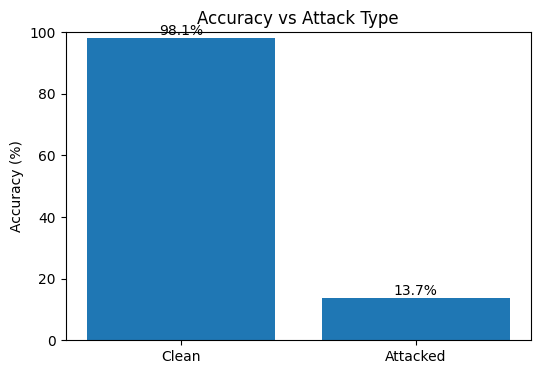

In [ ]:
# ---- Produce all requested charts ----

# 1) Accuracy vs Attack Type
plot_accuracy_vs_attack_type(clean_acc_saved, attacked_acc_saved)



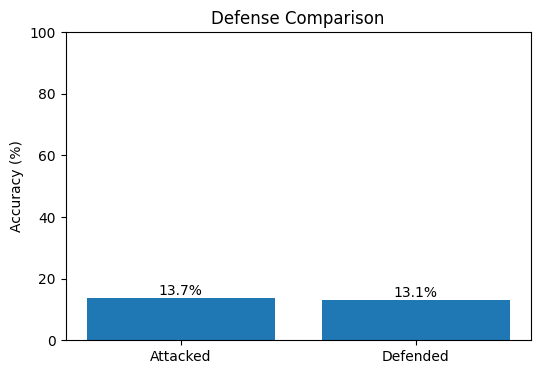

In [ ]:
# 2) Defense Comparison
plot_defense_comparison(attacked_acc_saved, defended_acc_saved)




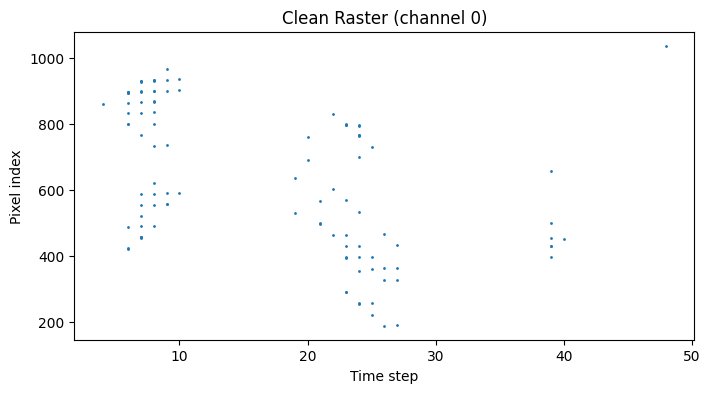

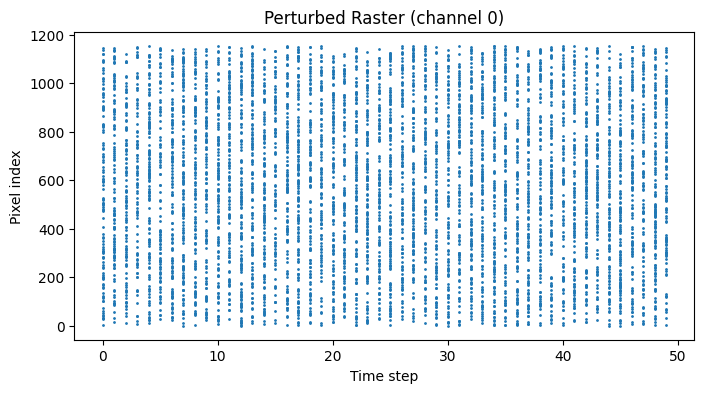

In [ ]:
# 3) Clean vs Perturbed Raster Plots
clean_sample, pert_sample = _get_clean_and_perturbed_samples()

if clean_sample is None:
    # Use demo frames
    clean_sample = _make_demo_frames()
    # "Perturb" demo by shifting a bit and adding random spikes
    pert_sample = torch.roll(clean_sample, shifts=2, dims=0).clone()
    mask_add = (torch.rand_like(pert_sample) < 0.02).float()
    pert_sample = torch.clamp(pert_sample + mask_add, 0.0, 1.0)

# The plotting helpers expect [T,C,H,W], so strip batch dim if present
clean_frames = clean_sample[0] if clean_sample.ndim == 5 else clean_sample
plot_raster(clean_frames, title="Clean Raster (channel 0)", channel=0)

if pert_sample is not None:
    pert_frames = pert_sample[0] if pert_sample.ndim == 5 else pert_sample
    plot_raster(pert_frames, title="Perturbed Raster (channel 0)", channel=0)
else:
    # If we couldn't generate a perturbed sample via mimicry_attack, we already created a demo above.
    plot_raster(pert_sample if pert_sample is not None else pert_frames,
                title="Perturbed Raster (channel 0)", channel=0)



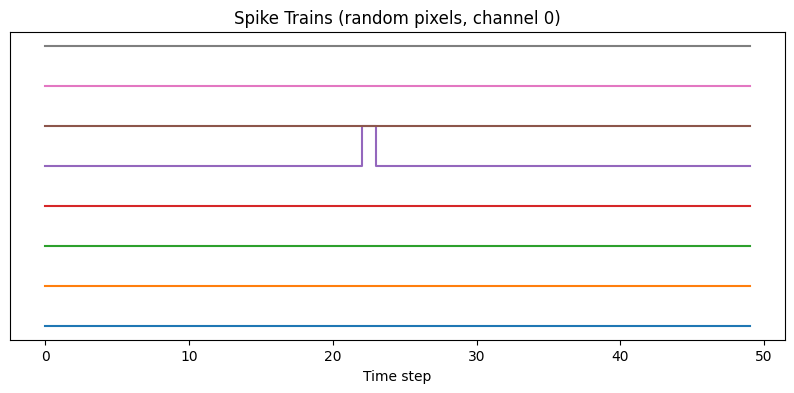

In [ ]:
# 4) Spike Trains Visualization
plot_spike_trains(clean_frames, num_traces=8, channel=0)

In [ ]:
# [EXTENSION] Phase 1: Define a Convolutional SNN Architecture
# Convolutional networks often handle spatial noise better than Dense networks.

class ConvSNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        beta = 0.9  # Decay rate for LIF neurons

        # Input: 2 channels (On/Off), 34x34
        self.conv1 = nn.Conv2d(2, 12, kernel_size=5)
        self.lif1 = snn.Leaky(beta=beta)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(12, 32, kernel_size=5)
        self.lif2 = snn.Leaky(beta=beta)
        self.pool2 = nn.MaxPool2d(2)

        self.flatten = nn.Flatten()

        # Calculate shape after conv/pool:
        # 34x34 -> Conv(k=5) -> 30x30 -> Pool(2) -> 15x15
        # 15x15 -> Conv(k=5) -> 11x11 -> Pool(2) -> 5x5
        # 32 channels * 5 * 5 = 800
        self.fc1 = nn.Linear(32 * 5 * 5, num_classes)
        self.lif3 = snn.Leaky(beta=beta)

    def forward(self, x):
        # x: [B, T, C, H, W]
        # Initialize hidden states
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk3_rec = []

        # Loop over time
        for step in range(x.size(1)):
            current_input = x[:, step] # [B, C, H, W]

            # Layer 1
            cur1 = self.conv1(current_input)
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1 = self.pool1(spk1)

            # Layer 2
            cur2 = self.conv2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2 = self.pool2(spk2)

            # Layer 3 (Output)
            cur3 = self.flatten(spk2)
            cur3 = self.fc1(cur3)
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)

        return torch.stack(spk3_rec, dim=1)

# Instantiate the new model
conv_model = ConvSNN(num_classes=10).to(device)
print("ConvSNN Model created.")

ConvSNN Model created.


In [ ]:
# [EXTENSION] Phase 2: Train the ConvSNN
# We perform a similar training loop to ensure a fair comparison.

optimizer_conv = torch.optim.Adam(conv_model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Redefine step_batch specifically for the conv model to avoid closure issues
def step_batch_conv(batch, model, optimizer, train=True):
    model.train(train)
    x, y = batch
    x = x.to(device).float()
    y = y.to(device).long()

    out_spk = model(x)
    spike_counts = out_spk.sum(dim=1)
    loss = criterion(spike_counts, y)

    if train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        pred = spike_counts.argmax(dim=1)
        acc = (pred == y).float().mean().item()
    return loss.item(), acc

# Training Loop
conv_epochs = 15
print(f"Training ConvSNN for {conv_epochs} epochs...")

start_time = time.time()
conv_history = {"test_acc": []}

for ep in range(1, conv_epochs + 1):
    conv_model.train()
    for batch in train_dl:
        step_batch_conv(batch, conv_model, optimizer_conv, train=True)

    # Evaluation
    conv_model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    with torch.no_grad():
        for batch in test_dl:
            l, a = step_batch_conv(batch, conv_model, optimizer_conv, train=False)
            bs = batch[0].size(0)
            total_loss += l * bs
            total_acc += a * bs
            n += bs
    test_acc = total_acc / n
    conv_history["test_acc"].append(test_acc)
    print(f"ConvSNN Epoch {ep}: Test Acc {test_acc:.4f}")

print(f"ConvSNN Training finished in {(time.time()-start_time)/60:.1f} minutes")

Training ConvSNN for 15 epochs...
ConvSNN Epoch 1: Test Acc 0.9646
ConvSNN Epoch 2: Test Acc 0.9755
ConvSNN Epoch 3: Test Acc 0.9740
ConvSNN Epoch 4: Test Acc 0.9814
ConvSNN Epoch 5: Test Acc 0.9696
ConvSNN Epoch 6: Test Acc 0.9816
ConvSNN Epoch 7: Test Acc 0.9748
ConvSNN Epoch 8: Test Acc 0.9807
ConvSNN Epoch 9: Test Acc 0.9855
ConvSNN Epoch 10: Test Acc 0.9852
ConvSNN Epoch 11: Test Acc 0.9859
ConvSNN Epoch 12: Test Acc 0.9863
ConvSNN Epoch 13: Test Acc 0.9855
ConvSNN Epoch 14: Test Acc 0.9858
ConvSNN Epoch 15: Test Acc 0.9862
ConvSNN Training finished in 67.1 minutes


Evaluating ConvSNN Robustness...
------------------------------
COMPARISON RESULTS
------------------------------
Dense SNN (TinySNN) Defended Accuracy: 13.13% (from previous run)
Conv SNN Defended Accuracy:            9.87%
------------------------------


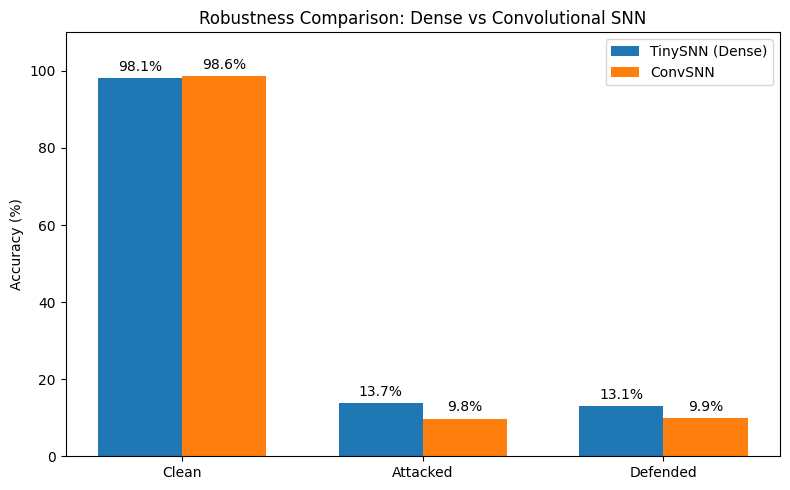

In [ ]:
# [EXTENSION] Phase 3: Evaluate ConvSNN against Attack and Defense
# Reuse the existing attack and defense dictionaries for fair comparison.

print("Evaluating ConvSNN Robustness...")

# Use the same parameters as the previous model
# attack_kwargs and defend_kwargs are already defined in previous cells

c_clean, c_attacked, c_defended, c_stats = evaluate_defended(
    conv_model, test_dl, mimicry_attack, attack_kwargs,
    defend_input, defend_kwargs, device=device, max_batches=None
)

print("-" * 30)
print("COMPARISON RESULTS")
print("-" * 30)
print(f"Dense SNN (TinySNN) Defended Accuracy: {defended_acc*100:.2f}% (from previous run)")
print(f"Conv SNN Defended Accuracy:            {c_defended*100:.2f}%")
print("-" * 30)

# Visualization Comparison
import matplotlib.pyplot as plt
import numpy as np

labels = ['Clean', 'Attacked', 'Defended']
dense_scores = [clean_acc*100, attacked_acc*100, defended_acc*100]
conv_scores = [c_clean*100, c_attacked*100, c_defended*100]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.figure(figsize=(8, 5)), plt.gca()
rects1 = ax.bar(x - width/2, dense_scores, width, label='TinySNN (Dense)')
rects2 = ax.bar(x + width/2, conv_scores, width, label='ConvSNN')

ax.set_ylabel('Accuracy (%)')
ax.set_title('Robustness Comparison: Dense vs Convolutional SNN')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.ylim(0, 110)
plt.tight_layout()
plt.show()